<a href="https://colab.research.google.com/github/BiswajitDeori/BB.github.io/blob/main/main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"biswajitdeori","key":"080516075b5f86425b24fe3471e2b444"}'}

In [4]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-10 18:11:20          15471  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9397  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4203  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3437  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [8]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 697M/714M [00:18<00:00, 43.2MB/s]
100% 714M/714M [00:18<00:00, 40.6MB/s]


In [9]:
!unzip lgg-mri-segmentation

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [10]:
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

In [11]:

ROOT_PATH = 'lgg-mri-segmentation/kaggle_3m/'
mask_files = glob.glob(ROOT_PATH+ '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

In [12]:
def diagnosis(mask_path):
  return 1 if np.max(cv2.imread(mask_path)) > 0 else 0



df=pd.DataFrame({"image_path":image_files,"mask_path":mask_files,"mask":[diagnosis(x) for x in mask_files]})


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_val = train_test_split(df,test_size = 0.2)
X_val,X_test = train_test_split(X_val,test_size = 0.5)
print("X_train Shape : ", X_train.shape)
print("X_val Shape : ", X_val.shape)
print("X_test Shape : ", X_test.shape)

X_train Shape :  (3143, 3)
X_val Shape :  (393, 3)
X_test Shape :  (393, 3)


In [14]:
from skimage import io
import cv2
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.utils.data_utils import Sequence

In [15]:
def train_generator(data_frame,batch_size,aug_dict,
                   image_color_mode = "rgb",
                   mask_color_mode = "grayscale",
                   image_save_prefix = "image_path",
                   mask_save_prefix = "mask_path",
                   save_to_dir = None,
                   target_size = (256,256),
                   seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    
    image_datagenerator = image_datagen.flow_from_dataframe(
         data_frame,
         x_col = "image_path",
         class_mode = None,
         color_mode = image_color_mode,
         target_size = target_size,
         batch_size = batch_size,
         save_to_dir = save_to_dir,
         save_prefix = image_save_prefix,
         seed = seed)
    
    mask_datagenerator = mask_datagen.flow_from_dataframe(
         data_frame,
         x_col = "mask_path",
         class_mode = None,
         color_mode = mask_color_mode,
         target_size = target_size,
         batch_size = batch_size,
         save_to_dir = save_to_dir,
         save_prefix = mask_save_prefix,
         seed = seed)
    
    train_gen = zip(image_datagenerator,mask_datagenerator)
    
    for (img,mask) in train_gen:
        img,mask = adjust_data(img,mask)
        yield (img,mask)


def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

In [16]:
def conv_block(input_tensor,filter_size,kernel_size = 3,batchnorm = True):
    
    # First layers of Convolution
    X = Conv2D(filters = filter_size,kernel_size = (kernel_size,kernel_size),\
              kernel_initializer = "he_normal", padding = "same")(input_tensor)
    
    if batchnorm:
        X = BatchNormalization()(X)
    
    X = Activation("relu")(X)
    
    # Second layers of Convolution
    X = Conv2D(filters = filter_size,kernel_size = (kernel_size,kernel_size),\
              kernel_initializer = "he_normal", padding = "same")(X)
    
    if batchnorm:
        X = BatchNormalization()(X)
    
    X = Activation("relu")(X)
    
    return X

In [17]:
def UNet(input_image, filter_size = 16, dropout = 0.1, batchnorm = True):
    
    # Encoder/Contracting Path of the Unet
    c1 = conv_block(input_image,filter_size * 1,kernel_size = 3,batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv_block(p1,filter_size * 2,kernel_size = 3,batchnorm = batchnorm)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv_block(p2,filter_size * 4,kernel_size = 3,batchnorm = batchnorm)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv_block(p3,filter_size * 8,kernel_size = 3,batchnorm = batchnorm)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(dropout)(p4)
    
    
    c5 = conv_block(p4,filter_size * 16,kernel_size = 3,batchnorm = batchnorm)
    
    # Decoder/Expanding Path of the Unet
    
    u6 = Conv2DTranspose(filter_size * 8,(2,2),strides = (2,2), padding = "same")(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv_block(u6,filter_size * 8,kernel_size = 3,batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(filter_size * 4,(2,2),strides = (2,2), padding = "same")(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv_block(u7,filter_size * 4,kernel_size = 3,batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(filter_size * 2,(2,2),strides = (2,2), padding = "same")(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv_block(u8,filter_size * 2,kernel_size = 3,batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(filter_size * 1,(2,2),strides = (2,2), padding = "same")(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv_block(u9,filter_size * 1,kernel_size = 3,batchnorm = batchnorm)
    
    
    outputs = Conv2D(1,(1,1) , activation = "sigmoid")(c9)
    model = Model(inputs = [input_image], outputs = outputs)
    return model
    

In [18]:
input_img = Input((256, 256, 3), name='img')
model = UNet(input_img, filter_size=16, dropout=0.2, batchnorm=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
def dice_coef(y_pred, Y, smooth = 100):
    y_flatten = K.flatten(Y)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_flatten * y_pred_flatten)
    union = K.sum(y_flatten) + K.sum(y_pred_flatten)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def jacard_coef(y_pred, Y,smooth = 100):
    y_flatten = K.flatten(Y)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_flatten * y_pred_flatten)
    union = K.sum(y_flatten) + K.sum(y_pred_flatten)
    jacard = (intersection + smooth) / (union - intersection + smooth)
    return jacard

def jacard_coef_loss(y_pred, Y):
    return -jacard_coef(y_pred, Y)


def dice_coef_loss(y_pred, Y):
    return -dice_coef(y_pred, Y)

In [32]:
BATCH_SIZE = 16
learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(X_train,BATCH_SIZE,
                           train_generator_args,
                           target_size = (256,256))

validation_gen = train_generator(X_val,BATCH_SIZE,
                           dict(),
                           target_size = (256,256))




In [33]:
earlystopping = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)

In [34]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
model.compile(optimizer = "adam", loss = dice_coef_loss, metrics = ["accuracy"])

In [36]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.0001,factor=0.1)

In [37]:
tf.keras.backend.clear_session()

In [38]:
checkpointer = ModelCheckpoint(filepath="UNet-segModel-weights.hdf5",verbose=1,save_best_only=True)

In [ ]:
history = model.fit(train_gen, steps_per_epoch=len(X_train) / BATCH_SIZE, epochs = 40, validation_data = validation_gen,
                    validation_steps=len(X_val) / BATCH_SIZE,verbose=1,shuffle=True,
                    callbacks = [earlystopping,checkpointer,reduce_lr])

Epoch 1/40
197/196 [==============================] - ETA: 0s - loss: -0.7552 - accuracy: 0.9955
Epoch 00001: val_loss did not improve from -0.68318
196/196 [==============================] - 90s 459ms/step - loss: -0.7552 - accuracy: 0.9955 - val_loss: -0.6613 - val_accuracy: 0.9958 - lr: 0.0010
Epoch 2/40
197/196 [==============================] - ETA: 0s - loss: -0.7306 - accuracy: 0.9951
Epoch 00002: val_loss did not improve from -0.68318
196/196 [==============================] - 90s 461ms/step - loss: -0.7306 - accuracy: 0.9951 - val_loss: -0.6658 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 3/40
197/196 [==============================] - ETA: 0s - loss: -0.7592 - accuracy: 0.9954
Epoch 00003: val_loss improved from -0.68318 to -0.73565, saving model to UNet-segModel-weights.hdf5
196/196 [==============================] - 91s 464ms/step - loss: -0.7592 - accuracy: 0.9954 - val_loss: -0.7357 - val_accuracy: 0.9963 - lr: 0.0010
Epoch 4/40
197/196 [==============================] - ETA

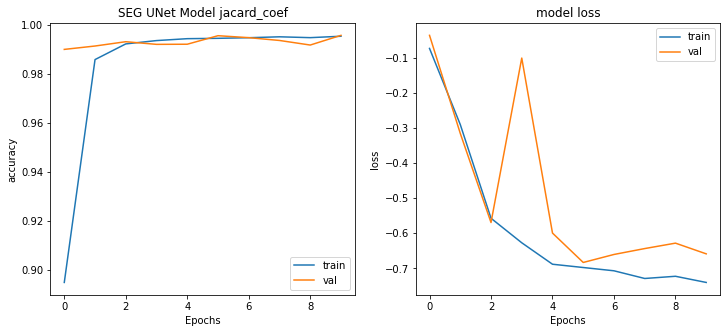

In [43]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("SEG UNet Model jacard_coef");
plt.ylabel("accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("model loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);